In [1]:
from rosemary import jpt_in_notebook
from llm.submit import submit_job, multiline_to_singleline

shell_scripts_template = """
echo "Running on $SLURM_JOB_NODELIST"
echo "======"

master_addr=$(scontrol show hostnames "$SLURM_JOB_NODELIST" | head -n 1)
master_port=10002
RDZV_ENDPOINT=$master_addr:$master_port

source ~/.profile
conda activate open-instruct
cd /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts

set -e
set -x
echo "======"
srun {cmd}

[ ! -f "{log_dir}/$SLURM_JOB_ID*.out" ] && mv {log_dir}/$SLURM_JOB_ID*.out {save_dir}
"""
log_dir = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/'

nodes = 1; gpus=6

test_run = 0
test_run = bool(test_run)


model_name = 'llama-7b'; model_name_or_path = '../results/baselines/huggyllama/llama-7b'
# model_name = 'llama-7b_ft=hmv1'; model_name_or_path = '../results/ft1/llama-7b_humanmix'
# model_name = 'pythia-160m-deduped'; model_name_or_path = 'EleutherAI/pythia-160m-deduped'
# model_name = 'pythia-1b-deduped'; model_name_or_path = 'EleutherAI/pythia-1b-deduped'

compute_grad = False; use_lora = False
compute_grad = True; use_lora = True; lora_rank = 256; lora_alpha = lora_rank


# datasets = ['cot', 'dolly', 'flan_v2', 'lima', 'oasst1']; nodes = 1; gpus=6; cpu_mem = 512
# datasets = ['tulu_v1_human_mix', 'tulu_v2_human_mix']; nodes = 1; gpus=1; cpu_mem = 64
# datasets = ['flan_v2']; nodes = 1; gpus=6; cpu_mem = 512
datasets = ['flan2022_1m']; nodes = 5; gpus=6; cpu_mem = 512

# # for testing
# datasets = ['lima']; nodes = 1; gpus=2; cpu_mem = 512

save_dir = (f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/"
            f"model_outputs/{model_name}")
if use_lora:
    save_dir += f'+lora:r={lora_rank}:a={lora_alpha}'


for dataset in datasets:
    cmd = f"""
    torchrun --nnodes={nodes} --nproc_per_node={gpus} \
        --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT \
        note_llama_embeddings.py \
        --dataset={dataset} \
        --model_name_or_path={model_name_or_path} \
        --save_dir={save_dir} \
        --use_dist \
        --shuffle \
        {'--compute_grad' if compute_grad else ''} \
        {'--use_lora' if use_lora else ''} \
        {'--lora_rank='+str(lora_rank) if use_lora else ''} \
        {'--lora_alpha='+str(lora_alpha) if use_lora else ''} \
    """
    cmd = multiline_to_singleline(cmd)

    shell_scripts = shell_scripts_template.format(
        cmd=cmd, log_dir=log_dir, save_dir=save_dir)
    out = submit_job(
        shell_scripts, 
        job_name=f'lm_outputs.{dataset}', 
        nodes=nodes,
        num_cpus=32,
        cpu_mem=cpu_mem,
        num_gpus=gpus,
        gpu_type='v100',
        test_run=test_run,
        job_duration=6,
    )
    print(cmd)
    if not test_run:
        print(out)


Submiting job with:
{
    "job_name": "lm_outputs.flan2022_1m",
    "nodes": 5,
    "num_cpus": 32,
    "cpu_mem": 512,
    "num_gpus": 6,
    "gpu_type": "v100",
    "test_run": false,
    "queue": "el8",
    "num_jobs": 1
}
torchrun --nnodes=5 --nproc_per_node=6 --rdzv-id=$SLURM_JOB_ID --rdzv-backend=c10d --rdzv-endpoint=$RDZV_ENDPOINT note_llama_embeddings.py --dataset=flan2022_1m --model_name_or_path=../results/baselines/huggyllama/llama-7b --save_dir=/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/llama-7b+lora:r=256:a=256 --use_dist --shuffle --compute_grad --use_lora --lora_rank=256 --lora_alpha=256
[{'args': 'sbatch --job-name=lm_outputs.flan2022_1m --partition=el8 --nodes=5 --ntasks-per-node=1 --cpus-per-task=32 --mem=512GB --gres=gpu:6 --output=/gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/%J.out --time=6:00:00 /gpfs/u/scratch/PTFM/PTFMqngp/github/mitibm2023/external/open-instruct/scripts/tmpp

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


In [ ]:
p = '/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/llama-7b/lima.pkl'
with open(p, 'rb') as f:
    x = pickle.load(f)
x

In [ ]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(10,5))

ax = axs[0]
ax.plot(np.exp(x['log_probs']), label='probs')
ax.plot(x['el2ns'], label='el2n')
ax.legend()

ax = axs[1]
ax.scatter(np.exp(x['log_probs']), x['el2ns'])
ax.set_xlabel('prob')
ax.set_ylabel('el2n')


In [ ]:
import os

processed_dir = '../data/processed'
datasets = []
for dataset in os.listdir(processed_dir) + ['tulu_v1_human_mix', 'tulu_v2_human_mix']:
    dataset_path = os.path.join(processed_dir, dataset)
    save_path = os.path.join(save_dir, f'{dataset}.pkl')
    if 'tulu'==dataset:
        continue
    if 'tulu' not in dataset and not os.path.isdir(dataset_path):
        continue
    if os.path.isfile(save_path):
        continue
    datasets.append(dataset)
    
datasets
    

In [1]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

if jpt_in_notebook():
    import os
    
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
#     os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
    
!nvidia-smi

/gpfs/u/scratch/PTFM/PTFMqngp/github/rosemary/src/rosemary/__init__.py:25: UserWarning: Install `torch` for functionalities dependent on torch
  warn(f'Install `torch` for functionalities dependent on torch')


Sat Oct  7 19:48:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000035:04:00.0 Off |                    0 |
| N/A   30C    P0    38W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000035:05:00.0 Off |                    0 |
| N/A   

In [2]:
from collections import defaultdict
from functools import partial
import os
import numpy as np
import time
import re
import random
import pickle
from tqdm import tqdm 
import pandas as pd


import pyarrow # import before `torch`, `transformers`, `datasets`
import torch
from torch.utils.data import DataLoader

from datasets import load_dataset

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

from open_instruct.finetune_trainer import encode_with_prompt_completion_format, encode_with_messages_format
from note_llama_embeddings import (
    combine_lm_outputs_for_mixes, 
    datasets_shard_chunk_size, 
    compute_losses, 
    compute_grad_statistic, 
    compute_grad_norm,
    print_trainable_parameters,
    get_grad_statistic_pattern,
)


[2023-10-07 19:48:45,460] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [54]:
test_run = True
dataset = 'lima'
dataset = 'flan_v2'
# dataset = 'oasst1'
use_dist = False
shuffle = True
compute_grad = True
use_lora = True
lora_rank = 512
lora_alpha = lora_rank

model_name = 'llama-7b'; model_name_or_path = '../results/baselines/huggyllama/llama-7b'
# model_name = 'pythia-1.4b'; model_name_or_path = '../results/baselines/EleutherAI/pythia-1.4b'
# model_name = 'pythia-160m-deduped'; model_name_or_path = 'EleutherAI/pythia-160m-deduped'


save_dir = f"/gpfs/u/home/PTFM/PTFMqngp/scratch/github/mitibm2023/external/open-instruct/scripts/model_outputs/{model_name}"
if not test_run:
    os.makedirs(save_dir, exist_ok=True)

In [55]:
if dataset in ['tulu_v1_human_mix', 'tulu_v2_human_mix']:
    combine_lm_outputs_for_mixes(dataset, save_dir)

if use_dist:
    dist.init_process_group("gloo", timeout=datetime.timedelta(hours=6))
    world_size = dist.get_world_size()
    rank = dist.get_rank() # global rank
    local_rank = int(os.environ["LOCAL_RANK"])
else:
    rank = 0
    local_rank = 0
    world_size = 1

print(f'rank/local_rank/world_size: {rank}/{local_rank}/{world_size}\n')

device = f'cuda:{str(local_rank)}'

rank/local_rank/world_size: 0/0/1



In [56]:
model = AutoModelForCausalLM.from_pretrained(
    model_name_or_path,
    device_map=device,
    torch_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(
    model_name_or_path, use_fast=True)
tokenizer.padding_side = 'left'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


In [57]:
if use_lora:
    if not compute_grad:
        raise ValueError('compute_grad must be True if use LoRA!')
    
    print(f'Initializing lora(r={lora_rank},a={lora_alpha})')
    # ensure the same initialization
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    
    if 'llama' in model_name_or_path:
        # target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj']
        target_modules = ['q_proj', 'k_proj', 'v_proj', 'o_proj']
    elif 'pythia' in model_name_or_path:
        target_modules = ['query_key_value']
    else:
        raise ValueError(f'Define new `target_modules` for LoraConfig for {model_name_or_path}')

    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM, 
        inference_mode=False, 
        bias='none',
        r=lora_rank,
        lora_alpha=lora_alpha, 
        lora_dropout=0.,
        target_modules=target_modules,
    )
    
    model.enable_input_require_grads()
    model = get_peft_model(model, peft_config)
    
    ## don't need to compute gradient to `lora_A`, saves computation (i think) but not space.
    for param_name, param in model.named_parameters():
        if param.requires_grad and 'lora_A' in param_name:
            param.requires_grad = False

print_trainable_parameters(model)

Initializing lora(r=512,a=512)
trainable params: 268435456 || all params: 7275286528 || trainable%: 3.69


In [87]:
w = model.base_model.model.model.layers[0].self_attn.q_proj.lora_A.default.weight
print(f'rank={rank}', w.min().cpu().item(), w.mean().cpu().item(), w.max().cpu().item(), w.norm().cpu().item())

rank=0 -0.01562499813735485 5.669414804287953e-06 0.01562497392296791 13.06145191192627


In [58]:

if compute_grad:
    if 'llama' in model_name_or_path:
        # Computing full gradient for llama is computationally prohibitive.
        # Use gradient checkpointing to prevent oom issues.
        # Note gradient checkpointing is only applied when in training mode
        #     https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L908
        # So need to set `model.train()`. This is harmless because
        # llama's eval/train computation is exactly the same, since there's no dropout layer.
        model.gradient_checkpointing_enable()
        model.train()
else:
    model.eval()

In [59]:
processed_dir = '../data/processed'
if 'flan2022' in dataset:
    train_file = os.path.join(processed_dir, 'flan2022', f'{dataset}_data.jsonl')
else:
    train_file = os.path.join(processed_dir, dataset, f'{dataset}_data.jsonl')
assert(os.path.isfile(train_file))


encode_function = partial(
    encode_with_messages_format, tokenizer=tokenizer, max_seq_length=2048)

if rank == 0:
    raw_datasets = load_dataset("json", data_files={'train': train_file})
    if test_run:
        raw_datasets['train'] = raw_datasets['train'].select(range(1000))
    print(f"{dataset} dataset length = {len(raw_datasets['train'])}")
    lm_datasets = raw_datasets.map(
        encode_function, batched=False, num_proc=16,
        desc="Tokenizing and reformatting instruction data")
if use_dist:
    dist.barrier()
if rank!= 0:
    raw_datasets = load_dataset("json", data_files={'train': train_file})
    if test_run:
        raw_datasets['train'] = raw_datasets['train'].select(range(1000))
    print(f"{dataset} dataset length = {len(raw_datasets['train'])}")
    lm_datasets = raw_datasets.map(
        encode_function, batched=False, num_proc=16,
        desc="Tokenizing and reformatting instruction data")

    

train_dataset = lm_datasets['train']
train_dataset.set_format(
    type="torch",
    output_all_columns=False,
    columns=['input_ids', 'labels', 'attention_mask'])
if shuffle:
    random.seed(0)
    shuffle_inds = list(range(len(train_dataset)))
    random.shuffle(shuffle_inds)
    reverse_shuffle_inds = [(i, ind) for i, ind in enumerate(shuffle_inds)]
    reverse_shuffle_inds = sorted(reverse_shuffle_inds, key=lambda x: x[1])
    reverse_shuffle_inds = [x[0] for x in reverse_shuffle_inds]
    train_dataset = train_dataset.select(shuffle_inds)
train_dataset_chunk_sizes = [datasets_shard_chunk_size(len(train_dataset), num_shards=world_size, index=i) 
            for i in range(world_size)]
train_dataset = train_dataset.shard(
    num_shards=world_size, 
    index=rank,
    contiguous=True)
loader = DataLoader(train_dataset, shuffle=False, batch_size=1, pin_memory=True) 

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-486fcbba36f2e93b/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-486fcbba36f2e93b/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-dbeef5a7f9797401_*_of_00016.arrow


flan_v2 dataset length = 1000


In [60]:

grad_statistic_patterns = get_grad_statistic_pattern(model_name_or_path, use_lora)
grad_statistic_patterns


{'loraB': 'lora_B\\.[a-zA-Z_]+\\.weight'}

In [61]:
from note_llama_embeddings import compute_grad_statistic
i = 0

output = defaultdict(list)
for batch in tqdm(loader, disable=rank!=0, total=len(loader)):
    batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
    
    if compute_grad:
        outputs = model(**batch, output_hidden_states=True, use_cache=False)
        model.zero_grad()
        outputs['loss'].backward()
    else:
        with torch.inference_mode():
            outputs = model(**batch, output_hidden_states=True)
    
    # (bsz, seq_len, hidden_size) -> (bsz, hidden_size)
    text_embedding = outputs['hidden_states'][-1].mean(1)
    output['text_embedding'].append(text_embedding.to(torch.float32).detach().cpu())
    
     # average of output token log probs
    output['log_prob'].append(-outputs['loss'].detach().cpu())
    
    # el2n scores
    losses = compute_losses(outputs['logits'], batch['labels'])
    for k in ['el2n_agg=mean', 'el2n_agg=l2n', 'logit_margin']:
        output[k].append(losses[k].detach().cpu())

    ## gradient statistic
    if compute_grad:
        grad_statistics = compute_grad_statistic(model, grad_statistic_patterns)
        for k, v in grad_statistics.items():
            output[f'grad_{k}'].append(v.detach().cpu())
    
    i += 1
    if i == 300:
        break
#     break
        
    
for k, v in output.items():
    output[k] = torch.vstack(v).to(torch.float32).numpy()
    

print(f'[local_rank/global={local_rank}/{rank}] '
      f'output={[(k, v.shape, v.dtype) for k, v in output.items()]}')

 30%|██▉       | 299/1000 [02:30<05:52,  1.99it/s]

[local_rank/global=0/0] output=[('text_embedding', (300, 4096), dtype('float32')), ('log_prob', (300, 1), dtype('float32')), ('el2n_agg=mean', (300, 1), dtype('float32')), ('el2n_agg=l2n', (300, 1), dtype('float32')), ('logit_margin', (300, 1), dtype('float32')), ('grad_loraB_l2n', (300, 1), dtype('float32'))]


In [80]:

param_names = []
grads = []
for param_name, param in model.named_parameters():
    if param.requires_grad and param.grad is not None:
        param_names.append(param_name)
        grads.append(param.grad.to(torch.float32))

data = []
for param_name, grad in zip(param_names, grads):
    data.append({
        'param_name': param_name,
        'shape': grad.shape,
        'numel': grad.numel(),
        'mean': grad.mean().detach().cpu().item(),
        'norm': grad.norm().detach().cpu().item(),
    })
        
        

df = pd.DataFrame(data)

# pattern = r'\bquery_key_value\.weight\b'
# # pattern = r'\bmlp\..*?\.weight\b'
pattern = r'\blora_B\b'

df = df[df['param_name'].apply(lambda x: True if re.search(pattern, x) else False)]
df = df.sort_values(['norm'], ascending=False)

df

,param_name,shape,numel,mean,norm
6,base_model.model.model.layers.1.self_attn.v_pr...,"(4096, 512)",2097152,3.309589e-08,0.952091
10,base_model.model.model.layers.2.self_attn.v_pr...,"(4096, 512)",2097152,-1.527118e-08,0.734453
2,base_model.model.model.layers.0.self_attn.v_pr...,"(4096, 512)",2097152,-3.344830e-07,0.467976
22,base_model.model.model.layers.5.self_attn.v_pr...,"(4096, 512)",2097152,-5.076922e-08,0.434146
30,base_model.model.model.layers.7.self_attn.v_pr...,"(4096, 512)",2097152,-1.266995e-07,0.424931
...,...,...,...,...,...
108,base_model.model.model.layers.27.self_attn.q_p...,"(4096, 512)",2097152,1.264275e-08,0.026321
5,base_model.model.model.layers.1.self_attn.k_pr...,"(4096, 512)",2097152,1.477039e-08,0.024496
109,base_model.model.model.layers.27.self_attn.k_p...,"(4096, 512)",2097152,-3.440975e-09,0.020781
1,base_model.model.model.layers.0.self_attn.k_pr...,"(4096, 512)",2097152,8.407061e-09,0.019470


(array([66., 25., 21.,  6.,  8.,  0.,  0.,  1.,  0.,  1.]),
 array([0.01400609, 0.10781454, 0.201623  , 0.29543145, 0.3892399 ,
        0.48304836, 0.57685681, 0.67066526, 0.76447371, 0.85828217,
        0.95209062]),
 <BarContainer object of 10 artists>)

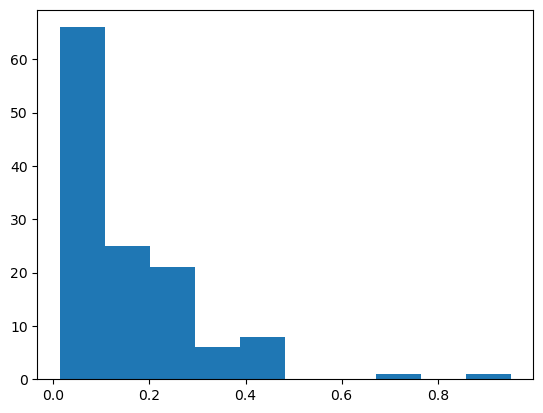

In [81]:
plt.hist(df['norm'].to_numpy())

(array([75., 22., 15.,  7.,  5.,  2.,  0.,  0.,  0.,  2.]),
 array([0.01864145, 0.12531811, 0.23199476, 0.33867141, 0.44534806,
        0.55202471, 0.65870136, 0.76537802, 0.87205467, 0.97873132,
        1.08540797]),
 <BarContainer object of 10 artists>)

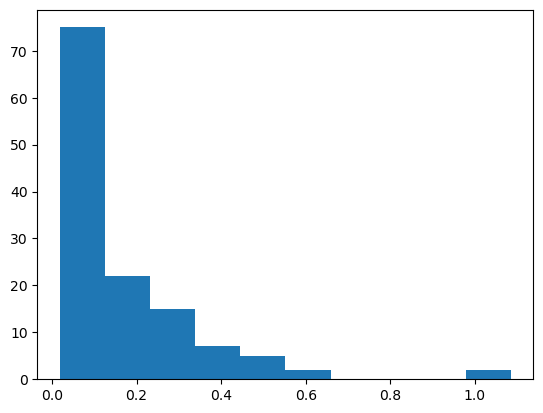

In [79]:
plt.hist(df['norm'].to_numpy())

In [17]:
# output_fullgrad = output.copy()

In [62]:

output_fullgrad.update({f'grad_loraB(r={lora_rank})_l2n': output['grad_loraB_l2n']})
# del output_fullgrad['grad_loraB_l2n']

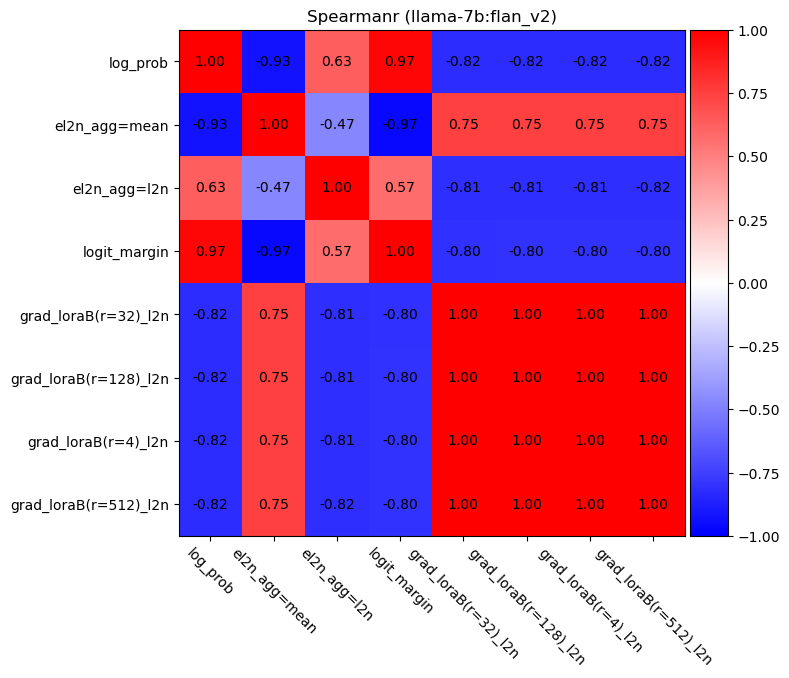

In [63]:
from rosemary import plt_kernel_matrix_one
import matplotlib.pyplot as plt
from scipy import stats

metrics_name = ['log_prob', 'el2n_agg=mean', 'el2n_agg=l2n', 'logit_margin']
metrics_name += [x for x in output_fullgrad if 'grad' in x and 'sum' not in x]
metrics = [output_fullgrad[k] for k in metrics_name]
any_isnan_mask = np.hstack([np.isnan(x) for x in metrics]).any(-1)
metrics = [x[~any_isnan_mask] for x in metrics]
N = len(metrics)
K = np.zeros((N, N))
for i, mi in enumerate(metrics):
    for j, mj in enumerate(metrics):
        s = stats.spearmanr(mi, mj)
        K[i,j] = s.statistic
        

fig, ax = plt.subplots(1,1,figsize=(8,8))
plt_kernel_matrix_one(
    fig, ax, K, title=f'Spearmanr ({model_name}:{dataset})', 
    vmin=-1, vmax=1, cmap='bwr', n_ticks=N, annotate=True)
ax.set_xticklabels(metrics_name, rotation=-45)
ax.set_yticklabels(metrics_name)

fig.tight_layout()

array([[0.7337741 ],
       [0.4971503 ],
       [0.3368366 ],
       [0.39310965],
       [0.33957723],
       [0.32302433],
       [0.29393336],
       [1.259916  ],
       [1.0904397 ],
       [0.19749328],
       [0.6159407 ],
       [1.3101168 ],
       [0.28377447],
       [0.713701  ],
       [0.2674226 ],
       [0.991541  ],
       [1.2790775 ],
       [0.25900862],
       [0.2934487 ],
       [0.5284021 ],
       [1.182624  ],
       [0.27685302],
       [1.0931882 ],
       [1.6186028 ],
       [0.26211146],
       [0.30602688],
       [1.0768642 ],
       [0.33676794],
       [0.3762995 ],
       [0.05822904],
       [0.35429898],
       [0.99870944],
       [0.18733303],
       [0.42744902],
       [1.690022  ],
       [0.39844003],
       [0.21763827],
       [0.22708143],
       [0.8608039 ],
       [0.8133187 ],
       [0.8917393 ],
       [1.5955082 ],
       [1.1689816 ],
       [0.871199  ],
       [1.0055825 ],
       [0.8185023 ],
       [0.50973684],
       [0.410